# Import Model

In [39]:
from cameo import models
from cameo import load_model
from cameo import fba
from escher import Builder
import pandas as pd
import numpy as np
import cobra
from time import sleep

# Simulate Model - WT E. coli

In [2]:
model = load_model('iML1515')
model.solver = 'gurobi'
model

Using license file /home/matinnu/gurobi.lic
Academic license - for non-commercial use only


Name,iML1515
Memory address,0x07f63f4dac790
Number of metabolites,1877
Number of reactions,2712
Number of groups,0
Objective expression,0.0 + 1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


In [4]:
%time fba_result = fba(model)
fba_result[model.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 266 ms, sys: 0 ns, total: 266 ms
Wall time: 256 ms


In [43]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


In [44]:
model.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
23.40%,8.504,ACKr,ac_c + atp_c <=> actp_c + adp_c
53.48%,19.44,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
23.12%,8.404,PYK,adp_c + h_c + pep_c --> atp_c + pyr_c
Percent,Flux,Reaction,Definition
23.08%,-8.39,ATPM,atp_c + h2o_c --> adp_c + h_c + pi_c
15.00%,-5.452,ATPS4r,adp_c + 4.0 h_e + pi_c <=> atp_c + h2o_c + 3.0 h_c
34.83%,-12.66,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
0.15%,-0.05412,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
26.93%,-9.789,PFK,atp_c + f6p_c --> adp_c + fdp_c + h_c


In [7]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_result.fluxes,
)
builder

Builder(reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022947509112696166, 'SHK3Dr': 0.3…

# Xylitol strain knockout model

In [8]:
# copy model to create mutant
mutant_xylitol = load_model('result/iML1515_xylitol_strain.xml')
mutant_xylitol.solver = 'gurobi'

In [9]:
%time fba_knockout_xylitol = fba(mutant_xylitol)
fba_knockout_xylitol[mutant_xylitol.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 328 ms, sys: 0 ns, total: 328 ms
Wall time: 373 ms


0.7776142830847736

In [45]:
mutant_xylitol.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004047,0,0.00%
cl_e,EX_cl_e,0.004047,0,0.00%
cobalt2_e,EX_cobalt2_e,1.944E-05,0,0.00%
cu2_e,EX_cu2_e,0.0005513,0,0.00%
fe2_e,EX_fe2_e,0.01249,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1518,0,0.00%
mg2_e,EX_mg2_e,0.006746,0,0.00%
mn2_e,EX_mn2_e,0.0005373,0,0.00%
mobd_e,EX_mobd_e,5.443E-06,0,0.00%


In [46]:
mutant_xylitol.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
69.39%,57.79,ATPS4rpp,adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
21.48%,17.89,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
9.13%,7.605,SUCOAS,atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
Percent,Flux,Reaction,Definition
0.00%,-0.0005202,4HTHRK,4hthr_c + atp_c --> adp_c + h_c + phthr_c
0.12%,-0.09925,AACPS3,ACP_c + atp_c + hdca_c --> amp_c + palmACP_c + ppi_c
0.14%,-0.117,AACPS4,ACP_c + atp_c + hdcea_c --> amp_c + hdeACP_c + ppi_c
0.07%,-0.06052,AACPS7,ACP_c + atp_c + ddca_c --> amp_c + ddcaACP_c + ppi_c
0.07%,-0.06052,ACCOAC,accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
0.28%,-0.23,ACGK,acglu_c + atp_c --> acg5p_c + adp_c


In [32]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_xylitol.fluxes,
)
builder.highlight_missing = True
builder

Builder(highlight_missing=True, reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.020347055…

# Isobutyric strain knockout model

In [11]:
# copy model to create mutant
mutant_isobutyric = load_model('result/iML1515_isobutyric_strain.xml')
mutant_isobutyric.solver = 'gurobi'

In [12]:
%time fba_knockout_isobutyric = fba(mutant_isobutyric)
fba_knockout_isobutyric[mutant_isobutyric.reactions.BIOMASS_Ec_iML1515_core_75p37M]

CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 281 ms


0.8769075284668423

In [47]:
mutant_isobutyric.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004564,0,0.00%
cl_e,EX_cl_e,0.004564,0,0.00%
cobalt2_e,EX_cobalt2_e,2.192E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006217,0,0.00%
fe2_e,EX_fe2_e,0.01408,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1712,0,0.00%
mg2_e,EX_mg2_e,0.007607,0,0.00%
mn2_e,EX_mn2_e,0.0006059,0,0.00%
mobd_e,EX_mobd_e,6.138E-06,0,0.00%


In [48]:
mutant_isobutyric.metabolites.atp_c.summary()

Percent,Flux,Reaction,Definition
75.73%,70.46,ATPS4rpp,adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
18.37%,17.09,PGK,3pg_c + atp_c <=> 13dpg_c + adp_c
5.90%,5.492,SUCOAS,atp_c + coa_c + succ_c <=> adp_c + pi_c + succoa_c
Percent,Flux,Reaction,Definition
0.00%,-0.0005867,4HTHRK,4hthr_c + atp_c --> adp_c + h_c + phthr_c
0.12%,-0.1119,AACPS3,ACP_c + atp_c + hdca_c --> amp_c + palmACP_c + ppi_c
0.14%,-0.1319,AACPS4,ACP_c + atp_c + hdcea_c --> amp_c + hdeACP_c + ppi_c
0.07%,-0.06824,AACPS7,ACP_c + atp_c + ddca_c --> amp_c + ddcaACP_c + ppi_c
0.07%,-0.06825,ACCOAC,accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
0.28%,-0.2594,ACGK,acglu_c + atp_c --> acg5p_c + adp_c


In [33]:
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    reaction_data=fba_knockout_isobutyric.fluxes,
)
builder
builder.highlight_missing = True
builder

Builder(highlight_missing=True, reaction_data={'CYTDK2': 0.0, 'XPPT': 0.0, 'HXPRT': 0.0, 'NDPK5': -0.022945162…

# Compare

In [18]:
normal_flux = fba_result.fluxes.to_frame()
normal_flux = normal_flux.rename(columns={'fluxes':'normal'})

In [19]:
xylitol_flux = fba_knockout_xylitol.fluxes.to_frame()
xylitol_flux = xylitol_flux.rename(columns={'fluxes':'xylitol'})

In [20]:
isobutyric_flux = fba_knockout_isobutyric.fluxes.to_frame()
isobutyric_flux = isobutyric_flux.rename(columns={'fluxes':'isobutyric'})

In [21]:
result = normal_flux.join(xylitol_flux)
result = result.join(isobutyric_flux)
result

,normal,xylitol,isobutyric
CYTDK2,0.000000,0.000000,0.000000
XPPT,0.000000,0.000000,0.000000
HXPRT,0.000000,0.000000,0.000000
NDPK5,-0.022948,-0.020347,-0.022945
SHK3Dr,0.334240,0.296364,0.334206
...,...,...,...
MPTS,0.000000,0.000000,0.000000
MOCOS,0.000000,0.000000,0.000000
BMOGDS2,0.000000,0.000000,0.000000
FESD2s,0.000000,0.000000,0.000000


In [22]:
flux_no_zeroes = (result != 0).any(axis=1)
flux_no_zeroes = result.loc[flux_no_zeroes]
flux_no_zeroes['d_xylitol'] = flux_no_zeroes['xylitol'] - flux_no_zeroes['normal']
flux_no_zeroes['d_isobutyric'] = flux_no_zeroes['isobutyric'] - flux_no_zeroes['normal']
flux_no_zeroes

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/matinnu/anaconda3/envs/lab_rotation_3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,normal,xylitol,isobutyric,d_xylitol,d_isobutyric
NDPK5,-0.022948,-0.020347,-0.022945,0.002600,2.346723e-06
SHK3Dr,0.334240,0.296364,0.334206,-0.037877,-3.418102e-05
NDPK8,0.000000,0.000000,0.022945,0.000000,2.294516e-02
DHORTS,-0.290106,-0.257231,-0.290077,0.032875,2.966767e-05
OMPDC,0.290106,0.257231,0.290077,-0.032875,-2.966767e-05
...,...,...,...,...,...
TYRL,0.000196,0.000173,0.000196,-0.000022,-1.999997e-08
THZPSN3,0.000196,0.000173,0.000196,-0.000022,-1.999997e-08
PAI2T,0.000393,0.000348,0.000393,-0.000045,-4.017931e-08
4HTHRK,0.000587,0.000520,0.000587,-0.000066,-5.999991e-08


In [23]:
delta_flux = flux_no_zeroes.drop(columns=['normal','xylitol','isobutyric'])

<AxesSubplot:>

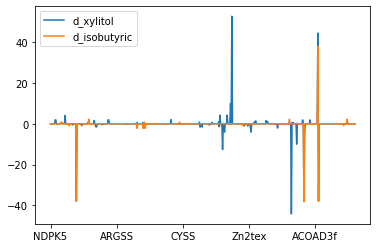

In [24]:
delta_flux.plot()

In [25]:
delta_flux.d_xylitol.nlargest(25)

CYTBDpp         52.839704
NADH16pp        44.570045
GLCtex_copy1    10.000000
O2tpp            4.291298
O2tex            4.291298
EX_co2_e         4.079213
AKGDH            2.043186
MDH              1.939550
FUM              1.939550
CS               1.936330
ICDHyr           1.936330
ACONTb           1.936330
ACONTa           1.936330
PGI              1.626776
PDH              1.621671
EX_h2o_e         1.454784
EX_nh4_e         1.073327
ENO              0.952028
Htex             0.913170
GLUDy            0.849856
GAPD             0.781305
ADK3             0.715788
DHAPT            0.673586
F6PA             0.673586
TPI              0.642735
Name: d_xylitol, dtype: float64

In [26]:
delta_flux.d_isobutyric.nlargest(25)

NADH16pp    38.022049
PYK2         2.257939
FBA          2.238706
PFK          2.238706
ALATA_L      0.881387
PPM          0.817950
PRPPS        0.817866
ADK1         0.817641
DHORD2       0.290077
PDH          0.077758
PGL          0.055753
GND          0.055753
G6PDH2r      0.055753
FLDR2        0.048732
TRDR         0.046614
RPE          0.037238
ATPS4rpp     0.026737
RNDR3        0.023691
NDPK7        0.023691
NDPK8        0.022945
RNDR1        0.022945
TKT2         0.018636
PFK_3        0.018602
TKT1         0.018602
FBA3         0.018602
Name: d_isobutyric, dtype: float64

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

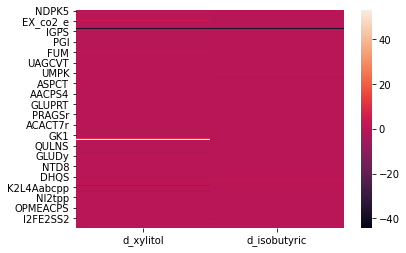

In [28]:
sns.heatmap(delta_flux)